# Embeddings Neuronales


**TODO**

### Importanción de librería requeridas

In [1]:
import gensim.corpora as corpora
from gensim.models import Word2Vec

from collections import Counter
import numpy as np

import pickle
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline


### Definición de variables globales

In [19]:
TEXT_FILE_READ = 'docs/preprocessing_reddit_data.csv'
TEXT_SAVE_FILE = 'docs/reddit_data_lda.csv'
FILENAME_PICKLE = "docs/tmpreddit.pickle"
n_clusters = 120

### Lectura de los comentarios de Reddit

Los comentarios fueron previamente preprocesados (Ver en TODO).

In [3]:
with open(FILENAME_PICKLE, 'rb') as f:
    df = pickle.load(f)


### Vocabulario

In [4]:
# Create Dictionary
id2word = corpora.Dictionary(df['lemma_tokens'])

# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)

# Creating a corpus object
corpus = [id2word.doc2bow(d) for d in df['lemma_tokens']]


In [5]:
processed_corpus = df['lemma_tokens']


### Entrenamiento del modelo Word2Vec

In [6]:
model = Word2Vec(sentences=processed_corpus, vector_size=100, window=5, min_count=1, workers=4)
model.train(processed_corpus, total_examples=len(processed_corpus), epochs=100)
model.save("word2vec.model")

In [7]:
word_vecs = []
vocabulary = list(model.wv.key_to_index)

for key in model.wv.key_to_index:
    word_vecs.append(model.wv[key])

In [8]:
# algunas predicciones

model.wv.most_similar("rucula")

[('jajajajjajaajaj', 0.9474700093269348),
 ('bottle', 0.923879861831665),
 ('laconcho', 0.9170483946800232),
 ('branding', 0.8742093443870544),
 ('submarinar', 0.8102405071258545),
 ('meanies', 0.8066320419311523),
 ('golden', 0.7551866173744202),
 ('wormtongue', 0.7354920506477356),
 ('aragorn', 0.7229427099227905),
 ('eyes', 0.7128532528877258)]

### Generación de vectores desde documentos

In [9]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized_docs = vectorize(processed_corpus, model=model)
len(vectorized_docs), len(vectorized_docs[0])



(27791, 100)

### Generación de clusters

In [10]:
def mbkmeans_clusters(
	X, 
    k, 
    mb, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = KMeans(n_clusters=k).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

Text(0.5, 1.0, 'Elbow curve')

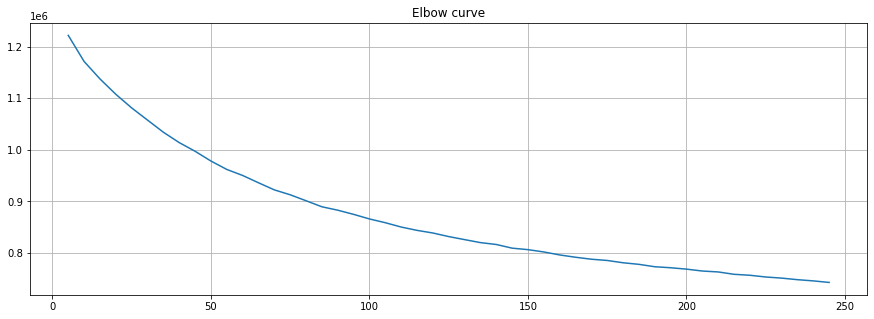

In [18]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

min = 5
max = 250
step = 5

distorsions = []
for k in range(min, max, step):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(vectorized_docs)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(min, max, step), distorsions)
plt.grid(True)
plt.title('Elbow curve')


In [20]:
clustering, cluster_labels = mbkmeans_clusters(
	X=vectorized_docs,
    k=n_clusters,
    mb=500,
    print_silhouette_values=True,
)
df_clusters = pd.DataFrame({
    "text": df["body"].values,
    "tokens": [" ".join(text) for text in processed_corpus],
    "cluster": cluster_labels
})



For n_clusters = 120
Silhouette coefficient: 0.02
Inertia:836082.9911208907
Silhouette values:
    Cluster 106: Size:11 | Avg:0.22 | Min:-0.06 | Max: 0.43
    Cluster 42: Size:161 | Avg:0.20 | Min:-0.00 | Max: 0.41
    Cluster 23: Size:311 | Avg:0.18 | Min:-0.01 | Max: 0.35
    Cluster 28: Size:117 | Avg:0.13 | Min:-0.11 | Max: 0.40
    Cluster 94: Size:65 | Avg:0.13 | Min:-0.01 | Max: 0.32
    Cluster 96: Size:103 | Avg:0.13 | Min:-0.07 | Max: 0.32
    Cluster 51: Size:181 | Avg:0.12 | Min:-0.09 | Max: 0.35
    Cluster 114: Size:143 | Avg:0.11 | Min:-0.05 | Max: 0.34
    Cluster 80: Size:109 | Avg:0.10 | Min:-0.12 | Max: 0.36
    Cluster 88: Size:110 | Avg:0.10 | Min:-0.07 | Max: 0.32
    Cluster 0: Size:151 | Avg:0.10 | Min:-0.12 | Max: 0.34
    Cluster 63: Size:215 | Avg:0.10 | Min:-0.14 | Max: 0.37
    Cluster 17: Size:218 | Avg:0.10 | Min:-0.10 | Max: 0.35
    Cluster 27: Size:239 | Avg:0.10 | Min:-0.12 | Max: 0.35
    Cluster 111: Size:144 | Avg:0.10 | Min:-0.09 | Max: 0.30
    C

### *Top terms* por cluster (basado en los centroides de los clusters)

In [21]:
print("Most representative terms per cluster (based on centroids):")
for i in range(n_clusters):
    tokens_per_cluster = ""
    most_representative = model.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=5)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")



Most representative terms per cluster (based on centroids):
Cluster 0: gustar wes filmografiar anderson motomel 
Cluster 1: x200b aepv mirandar mueva \>en 
Cluster 2: malo lecheeeee sedentarismo inclinacion desplumar 
Cluster 3: preguntar pregunta estapregunto responder consulta 
Cluster 4: ver tarkin perooooo serotonín sobresaturado 
Cluster 5: negro apurate blanco tortita pintamelo 
Cluster 6: pedrida\ \*quilombo \*supermercado territorio terrorista 
Cluster 7: mes usd recién mantenca suncho 
Cluster 8: ganar lidio ioooooo views boa 
Cluster 9: social plan argumetamos llenarlos zombies 
Cluster 10: gente mishandling mayoría creer dirijar 
Cluster 11: lindo hermoso vid estaba montón 
Cluster 12: paso nuuuu 8841761993739701954543615999998 divulgar machirulir 
Cluster 13: hijo pobretonto puta palmó pario 
Cluster 14: mep equilibrar peso imprimis arbitrar 
Cluster 15: mano \*mantenia agonir arquitectura cuek 
Cluster 16: problema frenarlo meli fobiar resolver 
Cluster 17: decir disruptor

### *Top terms* por cluster (basado en las palabras más frecuentes)

In [22]:
for i in range(n_clusters):
    tokens_per_cluster = ""
    most_frequent = Counter(" ".join(df_clusters.query(f"cluster == {i}")["tokens"]).split()).most_common(5)
    for t in most_frequent:
        tokens_per_cluster += f"{t[0]}({str(t[1])}) "
    print(f"Cluster {i}: {tokens_per_cluster}")


Cluster 0: gustar(154) fernet(5) gusto(5) calor(5) gente(4) 
Cluster 1: x200b(138) /s(29) gente(4) comentario(4) equis(3) 
Cluster 2: malo(98) entender(6) gente(5) año(4) sonar(4) 
Cluster 3: preguntar(83) responder(6) pregunta(5) gente(4) querer(4) 
Cluster 4: ver(348) él(50) gente(14) pasar(13) subir(9) 
Cluster 5: negro(85) blanco(37) mercado(8) empleado(5) morocho(4) 
Cluster 6: nacional(73) terrorista(42) mapuch(38) tierra(24) gobierno(23) 
Cluster 7: mes(124) año(9) pagar(6) cobrar(6) él(6) 
Cluster 8: ganar(163) noviembre(15) elección(14) voto(7) él(7) 
Cluster 9: social(64) plan(48) red(18) obra(17) justicia(6) 
Cluster 10: gente(272) creer(20) votar(17) él(14) mierdo(11) 
Cluster 11: lindo(113) hermoso(13) él(9) mina(6) historia(5) 
Cluster 12: paso(108) ver(5) gente(3) volver(3) él(3) 
Cluster 13: hijo(134) puta(62) madre(28) puto(24) padre(21) 
Cluster 14: peso(70) billete(62) pesos(49) dólar(36) dolar(33) 
Cluster 15: mano(130) él(19) querer(6) dedo(6) duro(6) 
Cluster 16: 

### Recupere los documentos más representativos (basados en los centroides de los clústeres) para un cluster en particular

In [23]:
test_cluster = 22
most_representative_docs = np.argsort(
    np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1)
)
for d in most_representative_docs[:10]:
    print( df["body"].values[d])
    print("-------------")

Se puede hacer dumpster diving en Argentina?
-------------
~~Cuba está así por el bloqueo~~  Argentina está así por la elite.
-------------
En Argentina no te aburrís nunca parte 2464
-------------
Lo deportan a la Argentina nuevamente*
-------------
De la ladrona de la nacion Argentina?
-------------
Vivís en un tupper, hay de todo en Argentina.
-------------
Primero de argentina y despues de latinoamerica, en ese orden
-------------
Alguien sabe por que no se puede usar coinbase en Argentina? ¿alguno de ustedes lo utiliza igual?
-------------
Si las Malvinas fuesen argentinas serían como Rafela, en Santa Fe [https://www.radiorafaela.com.ar/wp-content/uploads/2020/05/Rafaela-sin-actividades-1024x683-1.jpg](https://www.radiorafaela.com.ar/wp-content/uploads/2020/05/Rafaela-sin-actividades-1024x683-1.jpg)
-------------
[Se imaginan una Argentina sin la Kampora?](https://64.media.tumblr.com/8f3696b2abf97083d4ed3506178b8a1d/tumblr_nm92d7pECd1tszwcio1_640.jpg)
-------------


In [17]:
#solo test
#print(len(vectorized_docs))
#print(vectorized_docs[0])

test_v = vectorize([['defender', 'peso', 'siente', 'corazón', 'compro', 'pesos', 'tasa', 'fijo', 'año']], model=model)
prediction = clustering.predict(test_v)
print(prediction)

ver = "['defender', 'peso', 'siente', 'corazón', 'compro', 'pesos', 'tasa', 'fijo', 'año']"
ver = "tapastir baño tirar balde aguo"
test_v = vectorize([ver], model=model)
prediction = clustering.predict(test_v)
print(prediction)


str2 = ver.split(" ")
print(str2)

[43]
[16]
['tapastir', 'baño', 'tirar', 'balde', 'aguo']


In [24]:
reddit = pd.read_csv(TEXT_FILE_READ)

from sklearn.metrics import pairwise_distances


def get_cluster(row):
    test_v = vectorize([str(row).split(" ")], model=model)
    #print('****************')
    #print(clustering.fit_predict(test_v, 1))
    #print(clustering.predict(test_v))
    return clustering.predict(test_v)

reddit['cluster'] = reddit.apply(lambda row: get_cluster(row['body_preprocessing']) , axis = 1) 


In [25]:
# Show
reddit.head(10)

,score,id,flair,comms_num,body,comment_parent_id,is_replay,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,lemma_tokens,body_preprocessing,cluster
0,1,hfw14mt,Discusion🧐,1,todo para decir que tapaste el baño. tira un b...,q44kw3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['tapastir', 'baño', 'tirar', 'balde', 'aguo']",tapastir baño tirar balde aguo,[88]
1,1,hfw41eh,Discusion🧐,0,"sopapa primero master, si hay tapón te vas a t...",hfw14mt,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['sopapa', 'master', 'tapón', 'va', 'teñir', '...",sopapa master tapón va teñir medio,[32]
2,1,hfw1ao2,Discusion🧐,0,"Usas la sopapa, o tiras agua caliente con un b...",q44kw3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['sopapo', 'tira', 'agua', 'caliente', 'balde']",sopapo tira agua caliente balde,[19]
3,1,hfw3jof,Discusion🧐,2,Lo que he probado que siempre me dio resultado...,q44kw3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['probado', 'resultado', 'sellar', 'boca', 'in...",probado resultado sellar boca inodoro tirar ca...,[19]
4,1,hfw6v4i,Discusion🧐,0,Estas cobrando por dar mantenimiento y no sabe...,q44kw3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['cobrar', 'mantenimiento', 'carajo', 'kjjjjjj...",cobrar mantenimiento carajo kjjjjjjjjj vivirio...,[20]
5,1,hfw26iv,Discusion🧐,0,"Si tenes algo con punta, metelo y hace un poco...",q44kw3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['tén', 'punto', 'metelo', 'fuerza', 'romper',...",tén punto metelo fuerza romper tapo baño tirar...,[19]
6,1,hfw2gof,Discusion🧐,1,"Con una manguera para regar el jardín, si tene...",q44kw3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['regar', 'jardín', 'tén', 'pod', 'probar']",regar jardín tén pod probar,[53]
7,1,hfw5s13,Discusion🧐,0,"despues regas el jardin y se lava sola, solo q...",hfw2gof,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['rega', 'jardin', 'lava', 'tenés', 'lavarte',...",rega jardin lava tenés lavarte mano pulgar chorro,[15]
8,1,hfw3air,Discusion🧐,0,La respuesta real es que se venden unos caños ...,q44kw3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['respuesta', 'real', 'vender', 'caño', 'alamb...",respuesta real vender caño alambrado decir cañ...,[50]
9,7,hfvxa6w,Discusion🧐,3,Mi alfajor favorito es el Havana,q443eo,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['alfajor', 'favorito', 'haván']",alfajor favorito haván,[71]


In [26]:
reddit.to_csv(TEXT_SAVE_FILE, index=False)

In [27]:
for i in range(n_clusters):
    reddit[(reddit["cluster"] == i)][['flair', 'body']].to_csv('docs/testlda/' + str(i) + '.csv')
